<h1> <center>   Expresso Churn Prediction Challenge  </center> </h1>

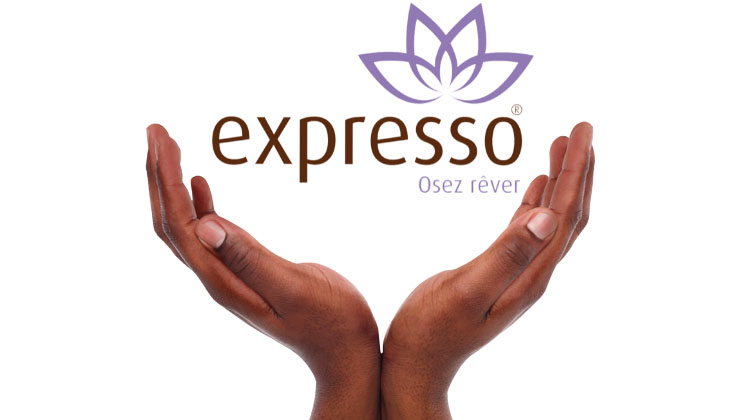

In [1]:
#loading libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from pandas_profiling import ProfileReport
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
import xgboost as xgb
from xgboost import plot_importance

## Exploration data analysis

### Variables decription


In [2]:
#var = pd.read_csv('VariableDefinitions.csv')



 - <b>user id 
 - Region  - the location of each client
 - Tenure - duration in the network
 - Montant - top-up Amount (кол-во средств на счете)
 - MRG - unclear
 - On net - inter expresso call
 - Orange - call to orange
 - regularity - number of times the client is active for 90 days
 - Revenue - montly income of each client
 - Tigo - call to Tigo
 - Top pack the most active packs
 - Zone1 - call to zones1
 - Zone2 - call to Zone2
 - APRU segment - income over 90 days/3. Average revenue of client
 - Data volume - number of connections
 - Freq top pack - number of times the client has activated the top pack packages
 - Frequence - number of times the client has made an income
 - Frequence rech - number of time the customer refilled (пополнил счет)
 
 

In [3]:
#var[['Variable Definitions','Unnamed: 2']]

### Data analysis and preprocessing

In [4]:
df = pd.read_csv('Train.csv')

In [5]:
df.describe()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,CHURN
count,1.397309e+06,1.397309e+06,1.428000e+06,1.428000e+06,1.428000e+06,1.093615e+06,1.367373e+06,1.258800e+06,864032.000000,169721.000000,136824.000000,2.154048e+06,1.251454e+06,2.154048e+06
mean,5.532117e+03,1.152912e+01,5.510810e+03,1.836943e+03,1.397814e+01,3.366450e+03,2.776891e+02,9.541871e+01,23.109253,8.170132,7.553309,2.804251e+01,9.272461e+00,1.875474e-01
std,7.111339e+03,1.327407e+01,7.187113e+03,2.395700e+03,1.469403e+01,1.330446e+04,8.726889e+02,2.049873e+02,63.578086,41.169511,33.487234,2.228686e+01,1.228044e+01,3.903504e-01
min,1.000000e+01,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.000000e+03,2.000000e+00,1.000000e+03,3.330000e+02,3.000000e+00,0.000000e+00,5.000000e+00,7.000000e+00,2.000000,0.000000,0.000000,6.000000e+00,2.000000e+00,0.000000e+00
50%,3.000000e+03,7.000000e+00,3.000000e+03,1.000000e+03,9.000000e+00,2.570000e+02,2.700000e+01,2.900000e+01,6.000000,1.000000,2.000000,2.400000e+01,5.000000e+00,0.000000e+00
75%,7.350000e+03,1.600000e+01,7.368000e+03,2.456000e+03,2.000000e+01,2.895000e+03,1.560000e+02,9.900000e+01,20.000000,3.000000,5.000000,5.100000e+01,1.200000e+01,0.000000e+00
max,4.700000e+05,1.330000e+02,5.321770e+05,1.773920e+05,9.100000e+01,1.823866e+06,5.080900e+04,2.132300e+04,4174.000000,4792.000000,3697.000000,6.200000e+01,7.130000e+02,1.000000e+00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154048 entries, 0 to 2154047
Data columns (total 19 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         object 
 1   REGION          object 
 2   TENURE          object 
 3   MONTANT         float64
 4   FREQUENCE_RECH  float64
 5   REVENUE         float64
 6   ARPU_SEGMENT    float64
 7   FREQUENCE       float64
 8   DATA_VOLUME     float64
 9   ON_NET          float64
 10  ORANGE          float64
 11  TIGO            float64
 12  ZONE1           float64
 13  ZONE2           float64
 14  MRG             object 
 15  REGULARITY      int64  
 16  TOP_PACK        object 
 17  FREQ_TOP_PACK   float64
 18  CHURN           int64  
dtypes: float64(12), int64(2), object(5)
memory usage: 312.2+ MB


In [7]:
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension --sys-prefix

In [8]:
df.MRG.value_counts()

NO    2154048
Name: MRG, dtype: int64

In [9]:
# MRG is exessive feature
df = df.drop(columns = ['MRG','user_id'])

In [10]:
df.TENURE.value_counts()

K > 24 month     2043201
I 18-21 month      45278
H 15-18 month      26006
G 12-15 month      14901
J 21-24 month      12725
F 9-12 month        9328
E 6-9 month         1839
D 3-6 month          770
Name: TENURE, dtype: int64

In [11]:
def tenure(x):
    'function to encode the Tenure based on the lowest amount of month spent'
    if x == 'K > 24 month':
        return 24
    elif x == 'H 15-18 month':
        return 15
    elif x == 'G 12-15 month':
        return 12
    elif x == 'J 21-24 month':
        return 21
    elif x == 'I 18-21 month':
        return 18
    elif x == 'E 6-9 month':
        return 6
    elif x == 'F 9-12 month':
        return 9
    elif x == 'D 3-6 month':
        return 3
    else:
        pass

In [12]:
#Transforming tenure to int format
df.TENURE = df.TENURE.apply(tenure)

In [13]:
df.iloc[:,1:]

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,24,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,54,On net 200F=Unlimited _call24H,8.0,0
1,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,1
2,24,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,17,On-net 1000F=10MilF;10d,1.0,0
3,24,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,62,"Data:1000F=5GB,7d",11.0,0
4,24,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,11,Mixt 250F=Unlimited_call24H,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154043,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,0
2154044,24,6100.0,15.0,5800.0,1933.0,15.0,621.0,26.0,40.0,40.0,NaN,NaN,55,"Data: 200 F=100MB,24H",9.0,0
2154045,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1
2154046,24,10000.0,11.0,7120.0,2373.0,13.0,NaN,0.0,140.0,13.0,NaN,NaN,28,All-net 500F=2000F;5d,12.0,0


In [14]:
df.query('FREQ_TOP_PACK == 0')

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN


In [15]:
df.REGULARITY.value_counts()

1     195162
62    166477
2     118915
3      86027
4      68335
       ...  
31     19547
34     19478
33     19466
35     19451
36     19091
Name: REGULARITY, Length: 62, dtype: int64

In [16]:
df.query('REGULARITY == 1 or REGULARITY == 2')

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
6,LOUGA,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,0
10,DAKAR,24,200.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,0
12,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,1
52,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1
54,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154027,THIES,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1
2154029,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,1
2154032,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,0
2154041,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,0


In [17]:
df.isna().sum() / df.shape[0]

REGION            0.394280
TENURE            0.000000
MONTANT           0.351310
FREQUENCE_RECH    0.351310
REVENUE           0.337062
ARPU_SEGMENT      0.337062
FREQUENCE         0.337062
DATA_VOLUME       0.492298
ON_NET            0.365208
ORANGE            0.415612
TIGO              0.598880
ZONE1             0.921208
ZONE2             0.936481
REGULARITY        0.000000
TOP_PACK          0.419022
FREQ_TOP_PACK     0.419022
CHURN             0.000000
dtype: float64

In [18]:
df.isnull().sum()

REGION             849299
TENURE                  0
MONTANT            756739
FREQUENCE_RECH     756739
REVENUE            726048
ARPU_SEGMENT       726048
FREQUENCE          726048
DATA_VOLUME       1060433
ON_NET             786675
ORANGE             895248
TIGO              1290016
ZONE1             1984327
ZONE2             2017224
REGULARITY              0
TOP_PACK           902594
FREQ_TOP_PACK      902594
CHURN                   0
dtype: int64

In [19]:
#Pandas Profiling provides a quicklook at all the features

#profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)

In [20]:
#in notebook tour of profile

#profile.to_widgets()

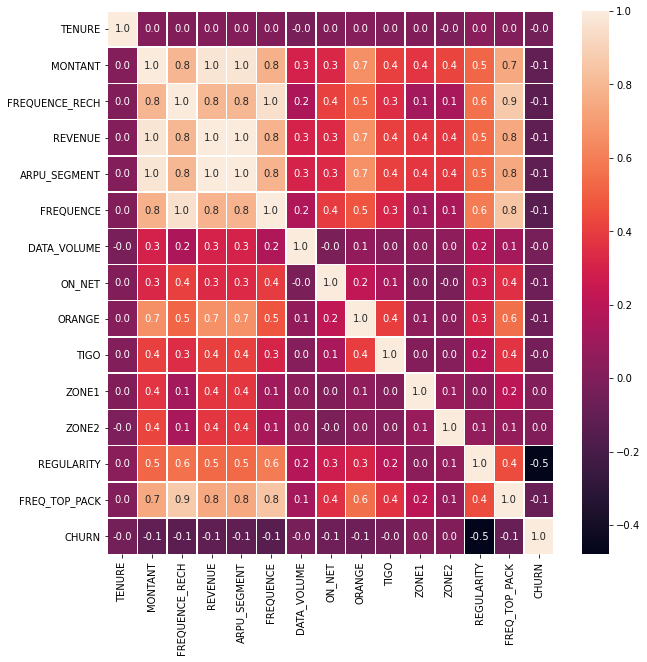

In [21]:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), annot=True ,linewidth=0.5,     fmt='.1f',ax=ax);

Text(0.5, 1.0, 'CHURN distribution')

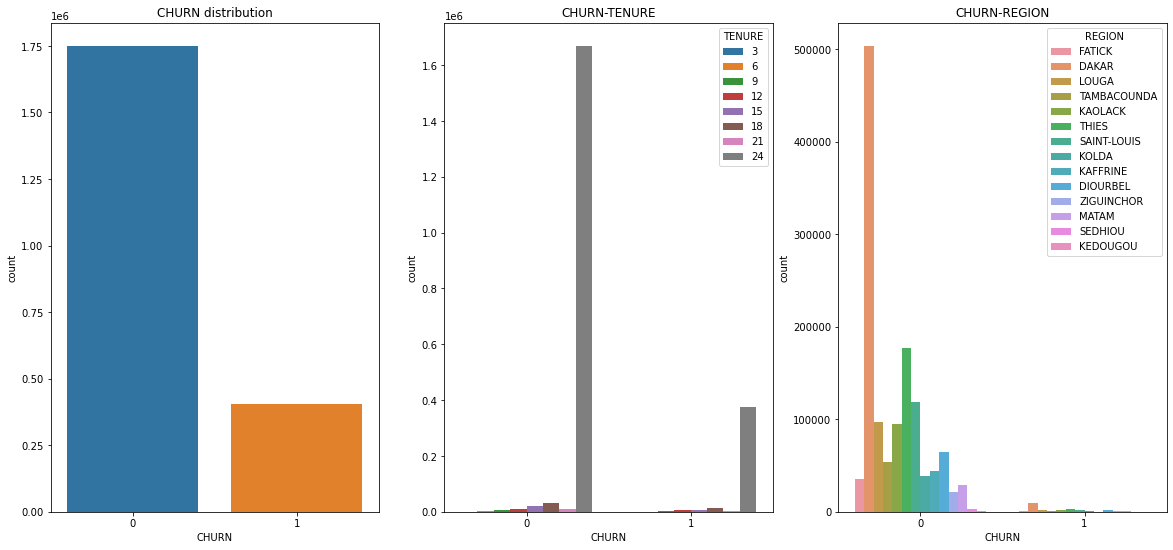

In [22]:
fig, axs = plt.subplots(1,3, figsize=(20, 9),sharex=True)
sns.countplot(x = df['CHURN'],ax=axs[0] )
sns.countplot(x=df['CHURN'], hue=df['TENURE'],data=df,ax=axs[1])
sns.countplot(x=df['CHURN'], hue=df['REGION'],data=df,ax=axs[2])
axs[1].title.set_text('CHURN-TENURE')
axs[2].set_title('CHURN-REGION')
axs[0].set_title('CHURN distribution')


<AxesSubplot:xlabel='CHURN', ylabel='ON_NET'>

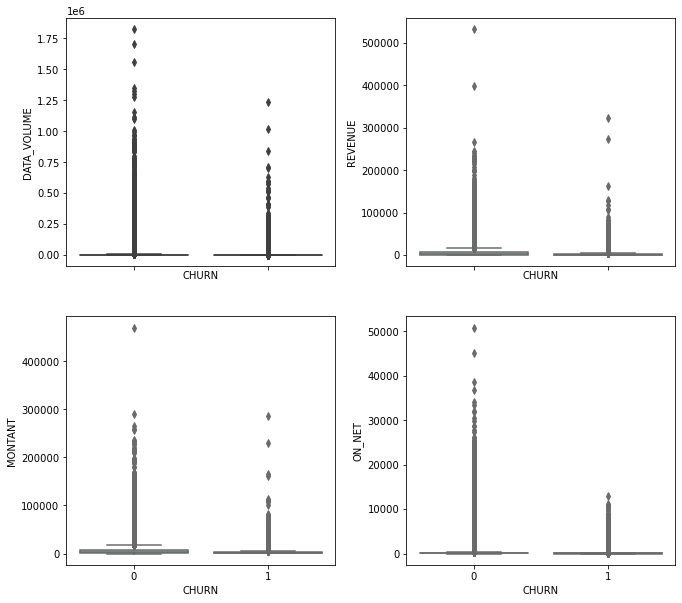

In [23]:
# Data contains a lot of noise. It is better to use a RobustScaler?
fig, axs = plt.subplots(2,2, figsize=(10, 9),sharex=True)
fig.tight_layout(pad=4.0)
sns.boxplot(x="CHURN", y="DATA_VOLUME", data=df,ax=axs[0,0])
sns.boxplot(x="CHURN", y="REVENUE", data=df, palette="Set3",ax=axs[0,1])
sns.boxplot(x="CHURN", y="MONTANT", data=df, palette="Set3",ax=axs[1,0])
sns.boxplot(x="CHURN", y="ON_NET", data=df, palette="Set3",ax=axs[1,1])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of regularity')

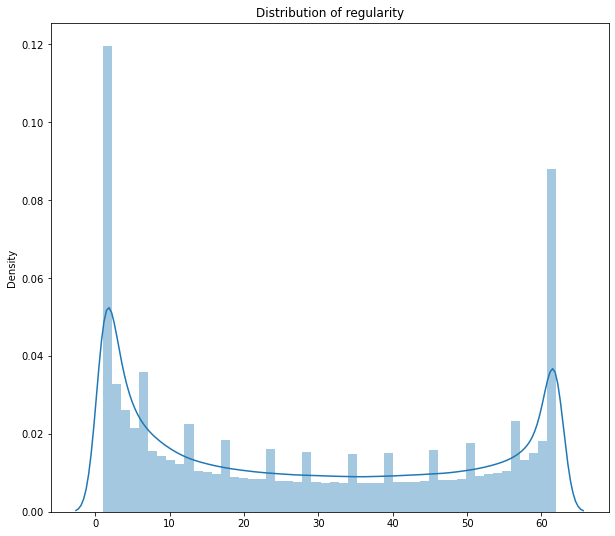

In [24]:
fig, axs = plt.subplots(1,1, figsize=(10, 9))
sns.distplot(x=df['REGULARITY'])
axs.set_title('Distribution of regularity')

<AxesSubplot:xlabel='CHURN', ylabel='count'>

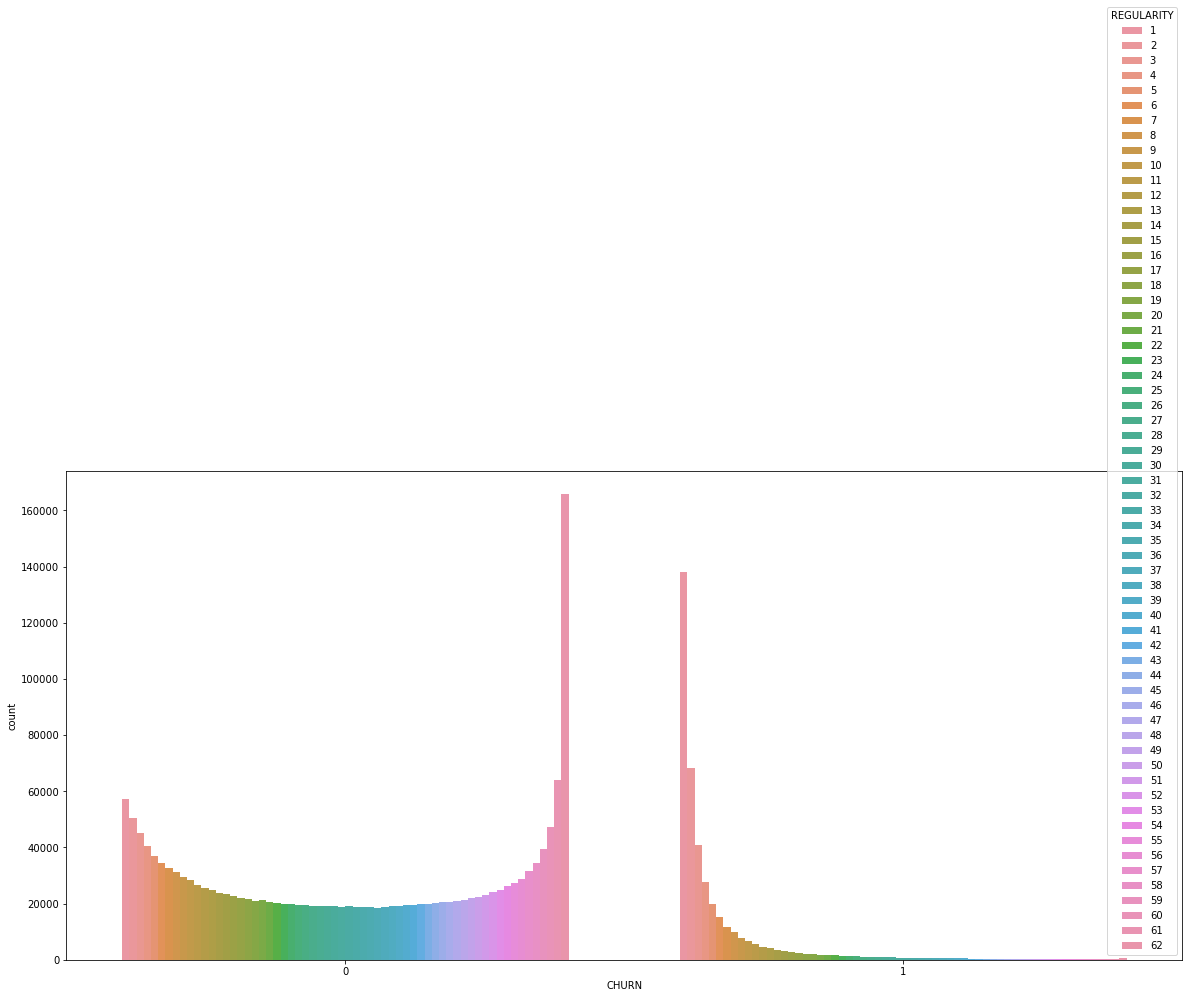

In [25]:
# Loyalty highly depends on Regularity

fig, axs = plt.subplots(1,1, figsize=(20, 9),sharex=True)
sns.countplot(x=df['CHURN'], hue=df['REGULARITY'])

In [26]:
df.TOP_PACK = df.TOP_PACK.fillna('others')

TOP_PACK_only = df[df['TOP_PACK'] != "others"]
no_PACK = df[df['TOP_PACK'] == "others"]

Text(0.5, 1.0, 'NO_PACK_users-CHURN')

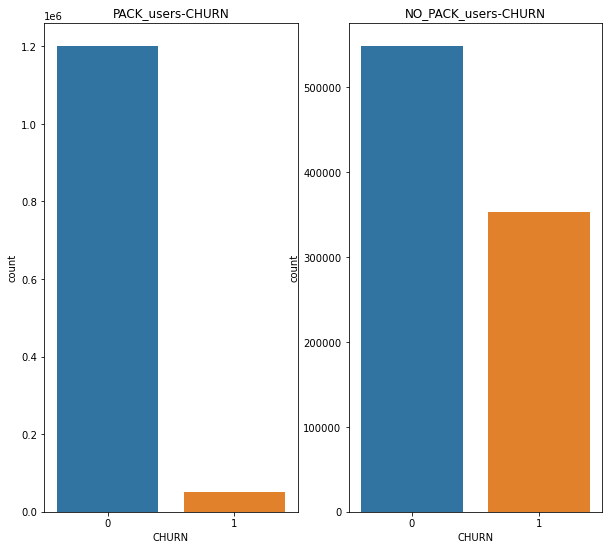

In [27]:
# People who use TOP_PACK are more loyal 
fig, axs = plt.subplots(1,2, figsize=(10, 9),sharex=True)
sns.countplot(x=TOP_PACK_only['CHURN'],ax=axs[0])
axs[0].set_title('PACK_users-CHURN')
sns.countplot(x=no_PACK['CHURN'],ax=axs[1])
axs[1].set_title('NO_PACK_users-CHURN')

In [28]:
## Montant value
df.TIGO = df.TIGO.fillna(-1)
zero_TIGO = df.query('TIGO == -1')

In [29]:
def tigo_encode(x):
    
    if x == -1:
        return 1
    else:
        return 0
    
df['TIG_encode'] = df.TIGO.apply(tigo_encode)

Text(0.5, 1.0, 'TIGO-CHURN')

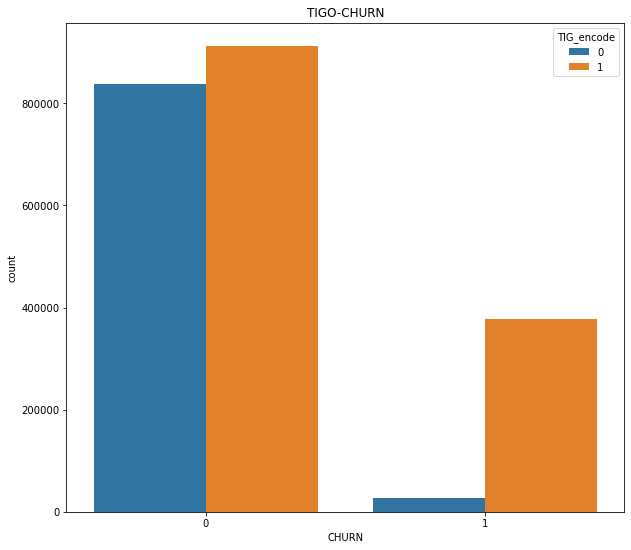

In [30]:
# It shows that unloyal customers don't usually call to the TIGO
fig, axs = plt.subplots(1,1, figsize=(10, 9),sharex=True)
sns.countplot(x=df['CHURN'],hue=df['TIG_encode'])
axs.set_title('TIGO-CHURN')

### Build a prepocessing function

In [31]:

def tenure(x):
    'function to encode the Tenure based on the lowest amount of month spent'
    # I think it's better to make a binary encoding. More than 24 month
    if x == 'K > 24 month':
        return 24
    elif x == 'H 15-18 month':
        return 15
    elif x == 'G 12-15 month':
        return 12
    elif x == 'J 21-24 month':
        return 21
    elif x == 'I 18-21 month':
        return 18
    elif x == 'E 6-9 month':
        return 6
    elif x == 'F 9-12 month':
        return 9
    elif x == 'D 3-6 month':
        return 3
    else:
        pass
'encode the REGULARITY based on the customer regularity'
def low_active_user(data): 
    if data <= 6:
        return 1
    else:
        return 0
    
def high_active_user(data):
    if data >=56:
        return 1
    else:
        return 0
def DAKAR_citizen(data):
    if data == "DAKAR":
        return 1
    else:
        return 0
        
    
    
def preprocess(data):
    data.TENURE = data.TENURE.apply(tenure)
    data['active_user'] = data.REGULARITY.apply(high_active_user)
    data['low_active_user'] = data.REGULARITY.apply(low_active_user)
    data['DAKAR_citizen'] = data.REGION.apply(DAKAR_citizen)
    data = data.drop(columns = ['MRG','user_id','ZONE1','ZONE2'])
    y = data.CHURN
    data = data.drop(columns = ['CHURN'])
    data = data['REGION'].fillna('Missing')
    data = data['FREQ']
    
    return data,y
    
    
    